# Distribution dans le temps des batailles renseignées dans Wikidata


In [1]:
from SPARQLWrapper import SPARQLWrapper, SPARQLWrapper2, JSON, TURTLE, XML, RDFXML
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
import pprint
import csv
import ast
import sys


from collections import Counter
from operator import itemgetter

import sqlite3 as sql
import time
import datetime
from dateutil import parser

from importlib import reload
from shutil import copyfile

import re

In [3]:
### Importer un module de fonctions crées ad hoc
##  ATTENTION : le fichier 'sparql_functions.py' doit se trouver 
#   dans un dossier qui se situe dans le chemin ('path') de recherche
#   vu par le présent carnet Jupyter afin que
#   l'importation fonctionne correctement

# Add parent directory to the path
sys.path.insert(0, '..')

### If you want to add the parent-parent directory,
#sys.path.insert(0, '../..')


import sparql_functions as spqf

## SPARQL Query qui récupère les données

On exécute la requête grâce à une fonction de la librairie locale qui réalise la mise en forme

In [4]:
## define SPARQL enpoint
endpoint = "https://query.wikidata.org/sparql"

In [5]:
query = """
SELECT DISTINCT ?item ?itemLabel ?coordinates ?battle_date ?start_time ?end_time
    WHERE {
        {
          {?item wdt:P31 wd:Q178561.
                 OPTIONAL {?item wdt:P625 ?coordinates.
                          ?item wdt:P585 ?battle_date}
                 OPTIONAL {?item wdt:P580 ?start_time;
                            wdt:P582 ?end_time}         
      FILTER(bound(?battle_date))

      # BIND(xsd:integer(REPLACE(str(?battle_date), "(.*)([0-9]{4})(.*)", "$2")) AS ?battle_year)
      
      SERVICE wikibase:label { bd:serviceParam wikibase:language "en" }
        }  
      }
    }  
"""

In [6]:
### Executer la requête avec les fonctions de la librairie locale
qr = spqf.get_json_sparql_result(endpoint,query)
r = [l for l in spqf.sparql_result_to_list(qr)]
print(len(r))
r[:3]

<class 'dict'>
6436


[['http://www.wikidata.org/entity/Q459447',
  'Siege of Yorktown',
  'Point(-76.5025 37.230833333)',
  '1781-01-01T00:00:00Z',
  '1781-09-28T00:00:00Z',
  '1781-10-19T00:00:00Z'],
 ['http://www.wikidata.org/entity/Q242644',
  'Battle of Caporetto',
  'Point(13.6425 46.214444444)',
  '1917-11-19T00:00:00Z',
  '1917-10-24T00:00:00Z',
  '1917-11-19T00:00:00Z'],
 ['http://www.wikidata.org/entity/Q326115',
  'Second Siege of Gerona',
  'Point(2.816666666 41.983333333)',
  '1808-08-16T00:00:00Z',
  '1808-07-24T00:00:00Z',
  '1808-08-16T00:00:00Z']]

In [7]:
### Créer un DataFrame à partir du résultat
df_b = pd.DataFrame(r)
df_b.columns = ['uri', 'label', 'geo_coordinates', 'battle_date', 'start_time', 'end_time']
df_b.head()

,uri,label,geo_coordinates,battle_date,start_time,end_time
0,http://www.wikidata.org/entity/Q459447,Siege of Yorktown,Point(-76.5025 37.230833333),1781-01-01T00:00:00Z,1781-09-28T00:00:00Z,1781-10-19T00:00:00Z
1,http://www.wikidata.org/entity/Q242644,Battle of Caporetto,Point(13.6425 46.214444444),1917-11-19T00:00:00Z,1917-10-24T00:00:00Z,1917-11-19T00:00:00Z
2,http://www.wikidata.org/entity/Q326115,Second Siege of Gerona,Point(2.816666666 41.983333333),1808-08-16T00:00:00Z,1808-07-24T00:00:00Z,1808-08-16T00:00:00Z
3,http://www.wikidata.org/entity/Q254797,Battle of Le Bourget,Point(2.42556 48.9353),1870-10-30T00:00:00Z,1870-09-27T00:00:00Z,1870-09-30T00:00:00Z
4,http://www.wikidata.org/entity/Q383614,Battle of Kohima,Point(94.103175 25.667645),1944-01-01T00:00:00Z,1944-04-04T00:00:00Z,1944-06-22T00:00:00Z


In [8]:
df_b.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6436 entries, 0 to 6435
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   uri              6436 non-null   object
 1   label            6436 non-null   object
 2   geo_coordinates  6436 non-null   object
 3   battle_date      6436 non-null   object
 4   start_time       6436 non-null   object
 5   end_time         6436 non-null   object
dtypes: object(6)
memory usage: 301.8+ KB


In [9]:
### Définir une fonction qui transformer l'année en entier
# avec signe positif si après J.C. ou négatif si avant J.C.
def f1(a):
    if a[0] == '-':
        r = int(a[:5])
    else:
        r = int(a[:4])
    return r     

In [10]:
### Tester la fonction 
# On peut changer les valeurs et observer le résultat
f1('-0390-01')

-390

In [11]:
### isoler le premier caractère de la date
bd = df_b.iloc[0]['battle_date']
print(bd, '-> ', bd[0])

1781-01-01T00:00:00Z ->  1


### Préparer à partir d'un exemple

In [12]:
df_b['year'] = df_b[df_b['label'].apply(lambda x : 'Cynoscephalae' in x)].apply(lambda x: f1(x['battle_date']), axis=1)

In [13]:
df_b[df_b['label'].apply(lambda x : 'Cynoscephalae' in x)]

,uri,label,geo_coordinates,battle_date,start_time,end_time,year
1658,http://www.wikidata.org/entity/Q391087,Battle of Cynoscephalae,Point(22.5667 39.4167),-0196-01-01T00:00:00Z,,,-196.0
3237,http://www.wikidata.org/entity/Q2334746,Battle of Cynoscephalae,Point(22.83 39.36),-0363-01-01T00:00:00Z,,,-363.0


### Transformer tout le tableau

In [14]:
df_b['year'] = df_b.apply(lambda x: f1(x['battle_date']), axis=1)

In [15]:
df_b[:3]

,uri,label,geo_coordinates,battle_date,start_time,end_time,year
0,http://www.wikidata.org/entity/Q459447,Siege of Yorktown,Point(-76.5025 37.230833333),1781-01-01T00:00:00Z,1781-09-28T00:00:00Z,1781-10-19T00:00:00Z,1781
1,http://www.wikidata.org/entity/Q242644,Battle of Caporetto,Point(13.6425 46.214444444),1917-11-19T00:00:00Z,1917-10-24T00:00:00Z,1917-11-19T00:00:00Z,1917
2,http://www.wikidata.org/entity/Q326115,Second Siege of Gerona,Point(2.816666666 41.983333333),1808-08-16T00:00:00Z,1808-07-24T00:00:00Z,1808-08-16T00:00:00Z,1808


# Calculer les durées

In [16]:
### Début de la bataille id = 4
st = df_b.iloc[4]['start_time']
st

'1944-04-04T00:00:00Z'

In [17]:
### Documentation sur l'import et le formatage des dates
# https://stackoverflow.com/questions/127803/how-do-i-parse-an-iso-8601-formatted-date-and-time
# package 'parser' from 'dateutil' library

stt = parser.parse(st)
stt

datetime.datetime(1944, 4, 4, 0, 0, tzinfo=tzutc())

In [18]:
### Fin de la bataille id = 4
et = df_b.iloc[4]['end_time']
ett = parser.parse(et)
et, ett

('1944-06-22T00:00:00Z', datetime.datetime(1944, 6, 22, 0, 0, tzinfo=tzutc()))

In [19]:
duration = ett - stt
days = duration.days
days

79

In [20]:
def get_duration(st, et):
    try:
        stt = parser.parse(st)
        ett = parser.parse(et)
        if st[:1] == '⁻':
            duration = stt - ett
        else:
            duration = ett - stt
        days = duration.days + 1
    except:
        days = -1
    return days



In [21]:
get_duration(st, et)

80

In [22]:
df_b['days_duration'] = df_b.apply(lambda x: get_duration(x['start_time'], x['end_time']), axis=1)

In [23]:
df_b[:10].sort_values(by='year', ascending=False)

,uri,label,geo_coordinates,battle_date,start_time,end_time,year,days_duration
4,http://www.wikidata.org/entity/Q383614,Battle of Kohima,Point(94.103175 25.667645),1944-01-01T00:00:00Z,1944-04-04T00:00:00Z,1944-06-22T00:00:00Z,1944,80
7,http://www.wikidata.org/entity/Q327052,Battle of Aachen,Point(6.083333333 50.776388888),1944-10-21T00:00:00Z,1944-10-02T00:00:00Z,1944-10-21T00:00:00Z,1944,20
8,http://www.wikidata.org/entity/Q327035,Battle of Gazala,Point(23.3575 32.145277777),1942-06-21T00:00:00Z,1942-05-26T00:00:00Z,1942-06-21T00:00:00Z,1942,27
9,http://www.wikidata.org/entity/Q254599,Battle of Shanghai,Point(121.469 31.2323),1937-11-26T00:00:00Z,1937-08-13T00:00:00Z,1937-11-26T00:00:00Z,1937,106
1,http://www.wikidata.org/entity/Q242644,Battle of Caporetto,Point(13.6425 46.214444444),1917-11-19T00:00:00Z,1917-10-24T00:00:00Z,1917-11-19T00:00:00Z,1917,27
3,http://www.wikidata.org/entity/Q254797,Battle of Le Bourget,Point(2.42556 48.9353),1870-10-30T00:00:00Z,1870-09-27T00:00:00Z,1870-09-30T00:00:00Z,1870,4
2,http://www.wikidata.org/entity/Q326115,Second Siege of Gerona,Point(2.816666666 41.983333333),1808-08-16T00:00:00Z,1808-07-24T00:00:00Z,1808-08-16T00:00:00Z,1808,24
5,http://www.wikidata.org/entity/Q376154,Battle of Copenhagen,Point(12.566666666 55.666666666),1807-01-01T00:00:00Z,1807-08-16T00:00:00Z,1807-09-05T00:00:00Z,1807,21
6,http://www.wikidata.org/entity/Q233426,Second Battle of Zurich,Point(8.55 47.366666666),1799-09-26T00:00:00Z,1799-09-25T00:00:00Z,1799-09-26T00:00:00Z,1799,2
0,http://www.wikidata.org/entity/Q459447,Siege of Yorktown,Point(-76.5025 37.230833333),1781-01-01T00:00:00Z,1781-09-28T00:00:00Z,1781-10-19T00:00:00Z,1781,22


In [24]:
df_b[df_b['start_time'].apply(lambda x : x[:1]=='-')]\
    .sort_values(by='year', ascending=False)

,uri,label,geo_coordinates,battle_date,start_time,end_time,year,days_duration
6406,http://www.wikidata.org/entity/Q1975400,Battle of the Nile,Point(31.11666667 30.9),-0046-01-01T00:00:00Z,-0047-09-01T00:00:00Z,-0046-01-01T00:00:00Z,-46,-607
197,http://www.wikidata.org/entity/Q131386,Battle of Alesia,Point(4.50027778 47.53722222),-0051-09-01T00:00:00Z,-0051-07-01T00:00:00Z,-0051-09-01T00:00:00Z,-51,63
1418,http://www.wikidata.org/entity/Q15934409,Siege of Namur,Point(4.86666667 50.46666667),-0053-01-01T00:00:00Z,-0053-01-01T00:00:00Z,-0053-01-01T00:00:00Z,-53,1
205,http://www.wikidata.org/entity/Q1055755,Battle of Ilipa,Point(-5.978333333 37.518333333),-0205-01-01T00:00:00Z,-0204-01-01T00:00:00Z,-0204-01-01T00:00:00Z,-205,1
679,http://www.wikidata.org/entity/Q2632506,Battle of Tarentum,Point(17.240833333 40.418055555),-0208-01-01T00:00:00Z,-0208-01-01T00:00:00Z,-0208-01-01T00:00:00Z,-208,1
660,http://www.wikidata.org/entity/Q2632522,Battle of Tarentum,Point(17.240833333 40.418055555),-0211-03-01T00:00:00Z,-0211-02-25T00:00:00Z,-0211-02-25T00:00:00Z,-211,1
213,http://www.wikidata.org/entity/Q917376,Battle of Agrigentum,Point(13.5833 37.3167),-0260-01-01T00:00:00Z,-0260-01-01T00:00:00Z,-0260-01-01T00:00:00Z,-260,1
239,http://www.wikidata.org/entity/Q917376,Battle of Agrigentum,Point(13.576547222 37.311075),-0260-01-01T00:00:00Z,-0260-01-01T00:00:00Z,-0260-01-01T00:00:00Z,-260,1
1221,http://www.wikidata.org/entity/Q2237798,Battle of Thebes,Point(23.323611111 38.324166666),-0334-12-01T00:00:00Z,-0334-01-01T00:00:00Z,-0334-01-01T00:00:00Z,-334,1
25,http://www.wikidata.org/entity/Q540205,Battle of Veii,Point(12.40138889 42.02388889),-0395-01-01T00:00:00Z,-0405-01-01T00:00:00Z,-0395-01-01T00:00:00Z,-395,-3652


## Détecter les doublons

In [25]:
gb_uri = df_b.groupby('uri').size()
gb_uri.loc[lambda x : x > 1]

uri
http://www.wikidata.org/entity/Q1018969      2
http://www.wikidata.org/entity/Q1028296      2
http://www.wikidata.org/entity/Q104541845    2
http://www.wikidata.org/entity/Q1049530      2
http://www.wikidata.org/entity/Q1066253      2
                                            ..
http://www.wikidata.org/entity/Q944855       2
http://www.wikidata.org/entity/Q964544       2
http://www.wikidata.org/entity/Q9651035      2
http://www.wikidata.org/entity/Q974166       2
http://www.wikidata.org/entity/Q983012       2
Length: 182, dtype: int64

In [26]:
gb_uri.loc[lambda x : x > 1].describe()

count    182.000000
mean       2.098901
std        0.394855
min        2.000000
25%        2.000000
50%        2.000000
75%        2.000000
max        4.000000
dtype: float64

In [27]:
### Effectif et trois instances
len(gb_uri.loc[lambda x : x > 1].index), gb_uri.loc[lambda x : x > 1].index[:3]

(182,
 Index(['http://www.wikidata.org/entity/Q1018969',
        'http://www.wikidata.org/entity/Q1028296',
        'http://www.wikidata.org/entity/Q104541845'],
       dtype='object', name='uri'))

In [28]:
### Les lignes concernées
df_b[df_b.uri.isin(gb_uri.loc[lambda x : x > 1].index)].sort_values(by='uri')

,uri,label,geo_coordinates,battle_date,start_time,end_time,year,days_duration
142,http://www.wikidata.org/entity/Q1018969,Siege of Van,Point(43.38 38.494166666),1915-05-17T00:00:00Z,1915-04-19T00:00:00Z,1915-05-17T00:00:00Z,1915,29
171,http://www.wikidata.org/entity/Q1018969,Siege of Van,Point(43.416666666 38.501944444),1915-05-17T00:00:00Z,1915-04-19T00:00:00Z,1915-05-17T00:00:00Z,1915,29
172,http://www.wikidata.org/entity/Q1028296,Battle of Grozny,Point(45.716666666 43.316666666),1994-12-31T00:00:00Z,1994-12-31T00:00:00Z,1995-02-08T00:00:00Z,1994,40
220,http://www.wikidata.org/entity/Q1028296,Battle of Grozny,Point(45.7 43.316666666),1994-12-31T00:00:00Z,1994-12-31T00:00:00Z,1995-02-08T00:00:00Z,1994,40
6253,http://www.wikidata.org/entity/Q104541845,Battle of Trocadero,Point(-6.223882151 36.521461599),1823-01-01T00:00:00Z,,,1823,-1
...,...,...,...,...,...,...,...,...
5454,http://www.wikidata.org/entity/Q9651035,Battle of Cerneja,Point(-8.789429 41.694778),1140-01-01T00:00:00Z,,,1140,-1
2435,http://www.wikidata.org/entity/Q974166,Battle of Montenotte,Point(8.276388888 44.398888888),1796-04-12T00:00:00Z,,,1796,-1
2412,http://www.wikidata.org/entity/Q974166,Battle of Montenotte,Point(8.26667 44.4),1796-04-12T00:00:00Z,,,1796,-1
2382,http://www.wikidata.org/entity/Q983012,Ottoman conquest of Adrianople,Point(26.5667 41.6667),1369-01-01T00:00:00Z,,,1369,-1


In [29]:
### Les lignes concernées
df_b[(df_b.uri.isin(gb_uri.loc[lambda x : x > 1].index)) & (df_b.start_time>'0')]

,uri,label,geo_coordinates,battle_date,start_time,end_time,year,days_duration
4,http://www.wikidata.org/entity/Q383614,Battle of Kohima,Point(94.103175 25.667645),1944-01-01T00:00:00Z,1944-04-04T00:00:00Z,1944-06-22T00:00:00Z,1944,80
20,http://www.wikidata.org/entity/Q1194227,Siege of Vannes,Point(-2.766666666 47.666666666),1342-01-01T00:00:00Z,1342-01-01T00:00:00Z,1343-01-21T00:00:00Z,1342,386
48,http://www.wikidata.org/entity/Q331565,Siege of Breisach,Point(7.58028 48.03278),1638-12-17T00:00:00Z,1638-08-18T00:00:00Z,1638-12-17T00:00:00Z,1638,122
52,http://www.wikidata.org/entity/Q331565,Siege of Breisach,Point(7.577431 48.032468),1638-12-17T00:00:00Z,1638-08-18T00:00:00Z,1638-12-17T00:00:00Z,1638,122
61,http://www.wikidata.org/entity/Q539707,Siege of Pirna,Point(13.933 50.967),1756-10-14T00:00:00Z,1756-09-11T00:00:00Z,1756-10-14T00:00:00Z,1756,34
...,...,...,...,...,...,...,...,...
6423,http://www.wikidata.org/entity/Q15277687,Siege of Mequinenza,Point(0.3025 41.374166666),1810-06-08T00:00:00Z,1810-05-15T00:00:00Z,1810-06-08T00:00:00Z,1810,25
6424,http://www.wikidata.org/entity/Q4890612,Siege of Al-Dāmūs,Point(-1.28333333 40.06666667),1210-01-01T00:00:00Z,1210-01-01T00:00:00Z,1210-01-01T00:00:00Z,1210,1
6428,http://www.wikidata.org/entity/Q4337448,Siege of Smolensk,Point(32.05 54.7833),1654-01-01T00:00:00Z,1654-06-01T00:00:00Z,1654-09-23T00:00:00Z,1654,115
6430,http://www.wikidata.org/entity/Q5036985,Capture of Berwick,Point(-2.0 55.766666666),1296-03-30T00:00:00Z,1296-03-29T00:00:00Z,1296-04-06T00:00:00Z,1296,9


In [30]:
df_b.sort_values(by='year', ascending=False)[:10]

,uri,label,geo_coordinates,battle_date,start_time,end_time,year,days_duration
6197,http://www.wikidata.org/entity/Q123014721,Battle of Zikim,Point(34.5037 31.6107),2023-10-01T00:00:00Z,,,2023,-1
6208,http://www.wikidata.org/entity/Q123369926,Battle of Beit Hanoun,Point(34.533333333 31.533333333),2023-01-01T00:00:00Z,,,2023,-1
6168,http://www.wikidata.org/entity/Q123290408,siege of Gaza City,Point(34.466666666 31.5),2023-11-01T00:00:00Z,,,2023,-1
6157,http://www.wikidata.org/entity/Q124736376,battle of Djibo,Point(-1.630555555 14.101111111),2023-11-26T00:00:00Z,,,2023,-1
6156,http://www.wikidata.org/entity/Q123058059,Battle of Sufa,Point(34.341388888 31.237222222),2023-10-01T00:00:00Z,,,2023,-1
1051,http://www.wikidata.org/entity/Q123302287,Battle of Ofakim,Point(34.616666666 31.316666666),2023-10-01T00:00:00Z,2023-10-07T00:00:00Z,2023-10-09T00:00:00Z,2023,3
1014,http://www.wikidata.org/entity/Q121756888,battle of Robotyne,Point(35.833333333 47.45),2023-01-01T00:00:00Z,2023-06-08T00:00:00Z,2023-08-01T00:00:00Z,2023,55
1021,http://www.wikidata.org/entity/Q111986066,Battle of the Siverskyi Donets,Point(38.0 49.0),2022-01-01T00:00:00Z,2022-05-05T00:00:00Z,2022-05-13T00:00:00Z,2022,9
984,http://www.wikidata.org/entity/Q112114966,Battle of Lysychansk,Point(38.416666666 48.916666666),2022-01-01T00:00:00Z,2022-02-26T00:00:00Z,2022-07-03T00:00:00Z,2022,128
999,http://www.wikidata.org/entity/Q111012552,Snake Island campaign,Point(30.204166666 45.255),2022-02-24T00:00:00Z,2022-02-24T00:00:00Z,2022-02-24T00:00:00Z,2022,1


In [31]:
df_b.describe()

,year,days_duration
count,6436.000000,6436.000000
mean,1589.162679,10.699503
std,533.803275,111.683899
min,-1500.000000,-3652.000000
25%,1517.750000,-1.000000
50%,1799.000000,-1.000000
75%,1904.000000,-1.000000
max,2023.000000,3391.000000


In [32]:
df_b[df_b.days_duration == -1]

,uri,label,geo_coordinates,battle_date,start_time,end_time,year,days_duration
1019,http://www.wikidata.org/entity/Q125092483,Q125092483,Point(30.035944 61.7085),1614-01-01T00:00:00Z,1614-08-06T00:00:00Z,http://www.wikidata.org/.well-known/genid/5816...,1614,-1
1455,http://www.wikidata.org/entity/Q155302,Battle of Loigny-Poupry,Point(1.73389 48.1239),1870-12-02T00:00:00Z,,,1870,-1
1456,http://www.wikidata.org/entity/Q131969,Battle of Thermopylae,Point(22.536944444 38.795833333),-0479-08-06T00:00:00Z,,,-479,-1
1457,http://www.wikidata.org/entity/Q201692,Battle of Poitiers,Point(0.39 46.54),1356-09-19T00:00:00Z,,,1356,-1
1458,http://www.wikidata.org/entity/Q201692,Battle of Poitiers,Point(0.39 46.54),1356-09-17T00:00:00Z,,,1356,-1
...,...,...,...,...,...,...,...,...
6323,http://www.wikidata.org/entity/Q113686825,Battle of Velyka Novosilka,Point(36.833333333 47.833333333),2020-01-01T00:00:00Z,,,2020,-1
6324,http://www.wikidata.org/entity/Q108872876,Q108872876,Point(16.115064 50.235657),1758-07-16T00:00:00Z,,,1758,-1
6325,http://www.wikidata.org/entity/Q116385387,Battle of Moshchun,Point(30.313333333 50.603611111),2022-01-01T00:00:00Z,,,2022,-1
6326,http://www.wikidata.org/entity/Q113642056,Battle of Dibrivka,Point(36.472222222 47.971944444),1918-09-30T00:00:00Z,,,1918,-1


In [33]:
df_b[df_b.days_duration > 100].describe()

,year,days_duration
count,156.000000,156.000000
mean,1734.038462,354.397436
std,307.026192,548.795451
min,617.000000,101.000000
25%,1601.500000,128.750000
50%,1893.500000,182.000000
75%,1943.000000,358.000000
max,2022.000000,3391.000000


In [34]:
len(df_b[df_b.days_duration > 152])

91

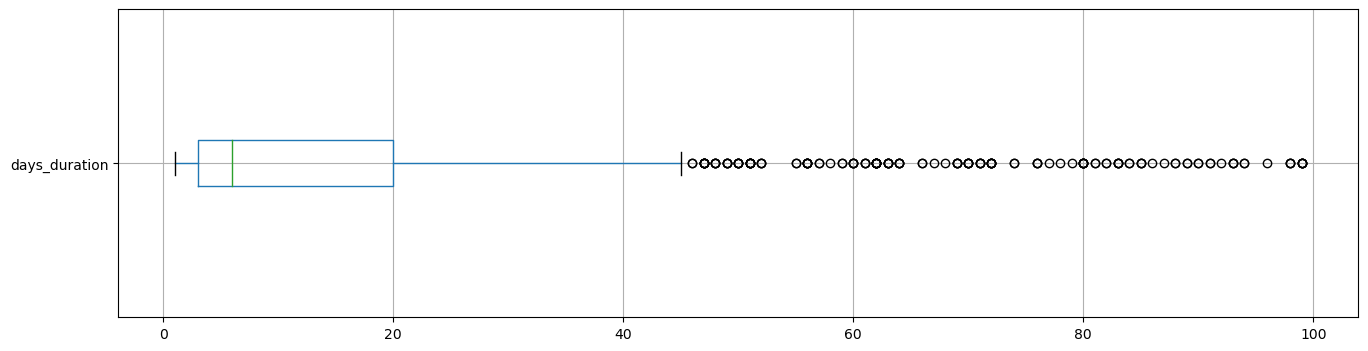

In [36]:
### Diagramme-boîte ou boîte-à-moustache pour représenter la dispersion
# Ligne centrale = la médiane. Le box est entre 1er et 3e quartile
# La moitié de la population se situe entre 31 et 68 ans
#  Noter qu'on utilise le DataFrame car cet objet dispose d'une méthode boxplot
# ce qui n'est pas le cas d'une série (pd.Series)
df_b[(df_b.days_duration > 0) & (df_b.days_duration < 100)].boxplot(column=['days_duration'], vert=False, figsize=(16,4))
plt.show()

In [37]:
df_b[(df_b.days_duration > 0) & (df_b.days_duration < 100)].days_duration.describe()

count    1401.000000
mean       15.995004
std        21.179622
min         1.000000
25%         3.000000
50%         6.000000
75%        20.000000
max        99.000000
Name: days_duration, dtype: float64

In [38]:
years_count = pd.DataFrame(df_b.groupby('year').size())\
                .reset_index(drop=False)
years_count.columns=['year','effectif']
years_count

,year,effectif
0,-1500,1
1,-1456,1
2,-1324,1
3,-1273,1
4,-1249,1
...,...,...
1283,2019,8
1284,2020,15
1285,2021,6
1286,2022,20


In [39]:
years_count.effectif.max()

122

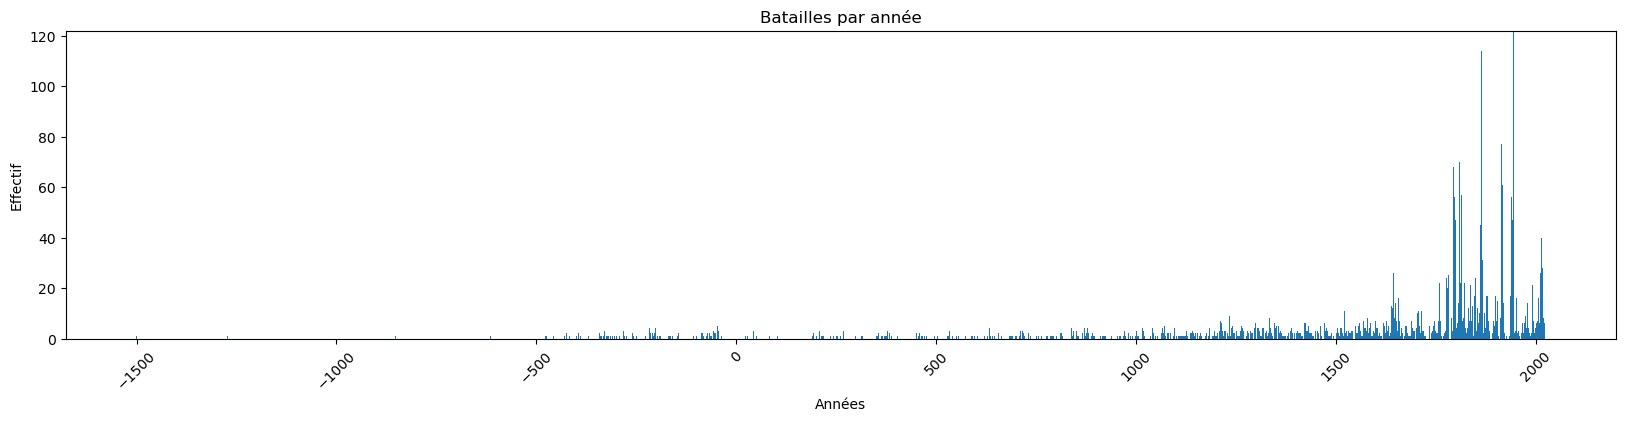

In [40]:
# Effectifs par année

objects = years_count['year']
eff = years_count['effectif']


p1 = plt.bar(objects, eff, width=1)

#plt.xticks(l5Years)
plt.ylabel('Effectif')
plt.xlabel('Années')
plt.title('Batailles par année')
plt.gcf().set_size_inches(20,4)
plt.ylim(0,max(eff))
#plt.gca().axes.get_xaxis().set_visible(False)
# supported formats: eps, pdf, pgf, png, ps, raw, rgba, svg, svgz
#plt.savefig('exported_pictures/effectifs_naissances_par_annee.png', dpi=100, bbox_inches = "tight") #pdf, svg
plt.xticks(rotation=45)
plt.show()

In [41]:
# Effectifs par année

objects = years_count['year']
eff = years_count['effectif']

years_between = years_count[(years_count.year >1000) & (years_count.year < 1200) ]

print(years_between.head())

     year  effectif
440  1001         3
441  1003         1
442  1004         1
443  1006         1
444  1009         1


In [42]:
years_between.plot(kind='bar', x='year', figsize=(20,4), rot=45, fontsize=6)

<Axes: xlabel='year'>

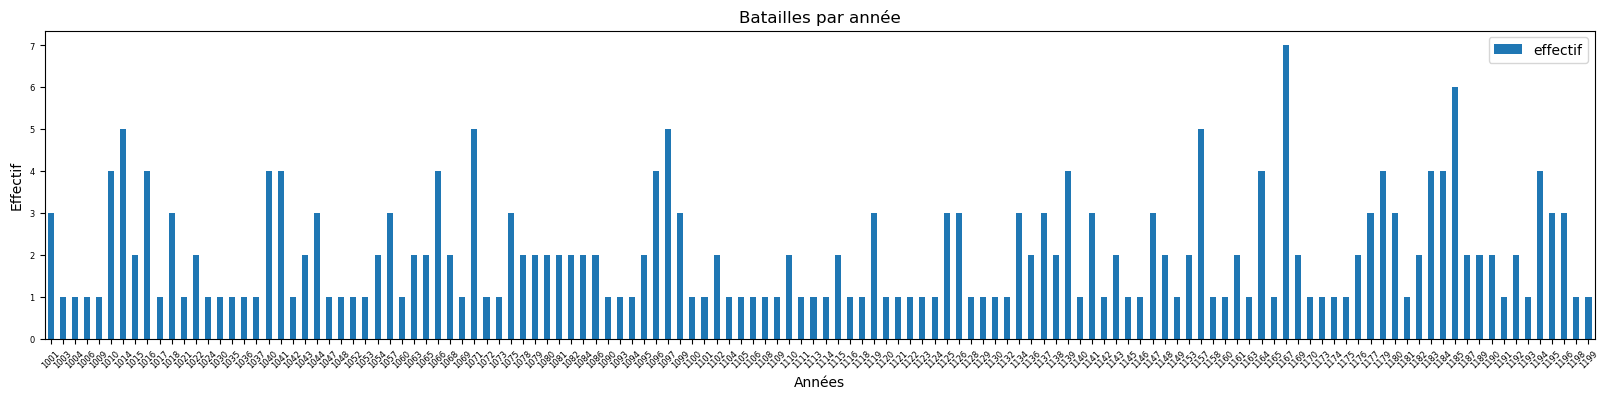

In [43]:
### Attention représentation fautive: il n'y a pas de trous !
# L'axe du temps est donc faussé, il est plus court que qu'il doit être

objects = years_between['year']
eff = years_between['effectif']


p1 = plt.bar(objects, eff, width=0.5)

#plt.xticks(l5Years)
plt.ylabel('Effectif')
plt.xlabel('Années')
plt.title('Batailles par année')
plt.gcf().set_size_inches(20,4)
#plt.gca().axes.get_xaxis().set_visible(False)
# supported formats: eps, pdf, pgf, png, ps, raw, rgba, svg, svgz
#plt.savefig('exported_pictures/effectifs_naissances_par_annee.png', dpi=100, bbox_inches = "tight") #pdf, svg
plt.xticks(rotation=45)
plt.show()

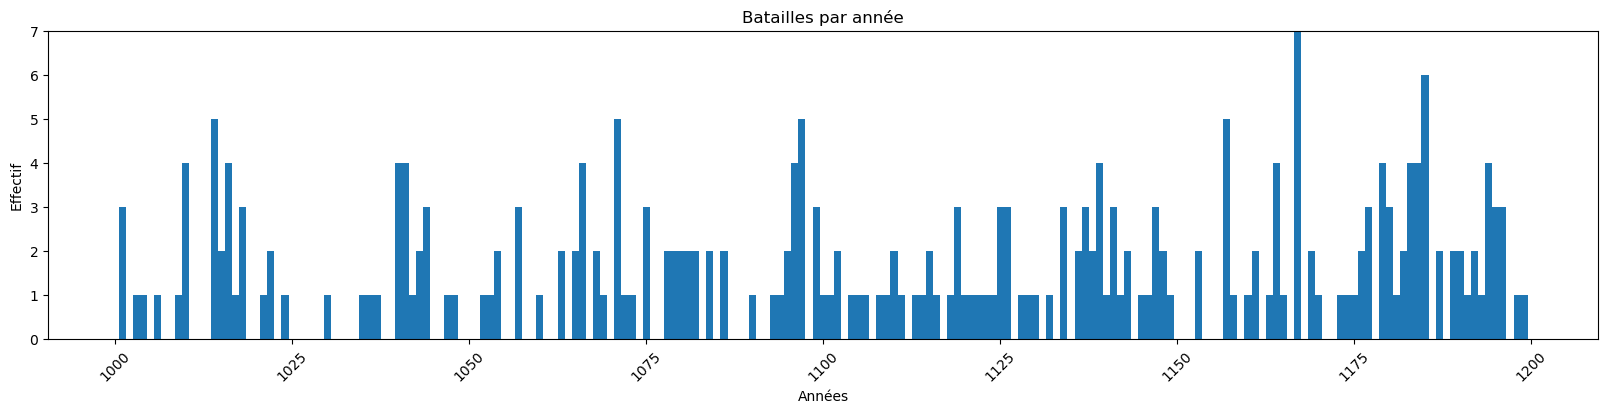

In [44]:
# Effectifs par année

objects = years_between['year']
eff = years_between['effectif']



p1 = plt.bar(objects, eff, width=1)

#plt.xticks(l5Years)
plt.ylabel('Effectif')
plt.xlabel('Années')
plt.title('Batailles par année')
plt.gcf().set_size_inches(20,4)
plt.ylim(0,max(eff))
#plt.gca().axes.get_xaxis().set_visible(False)
# supported formats: eps, pdf, pgf, png, ps, raw, rgba, svg, svgz
#plt.savefig('exported_pictures/effectifs_naissances_par_annee.png', dpi=100, bbox_inches = "tight") #pdf, svg
plt.xticks(rotation=45)
plt.show()

## Regrouper par périodes de 25 ans

In [51]:
### Créer une copie indépendante du DataFrame (attention aux copies de variables qui sont seulement des alias) 
cdf_b = df_b[df_b['year'] > 1000].copy(deep=True)

In [52]:
cdf_b.head()

,uri,label,geo_coordinates,battle_date,start_time,end_time,year,days_duration
0,http://www.wikidata.org/entity/Q459447,Siege of Yorktown,Point(-76.5025 37.230833333),1781-01-01T00:00:00Z,1781-09-28T00:00:00Z,1781-10-19T00:00:00Z,1781,22
1,http://www.wikidata.org/entity/Q242644,Battle of Caporetto,Point(13.6425 46.214444444),1917-11-19T00:00:00Z,1917-10-24T00:00:00Z,1917-11-19T00:00:00Z,1917,27
2,http://www.wikidata.org/entity/Q326115,Second Siege of Gerona,Point(2.816666666 41.983333333),1808-08-16T00:00:00Z,1808-07-24T00:00:00Z,1808-08-16T00:00:00Z,1808,24
3,http://www.wikidata.org/entity/Q254797,Battle of Le Bourget,Point(2.42556 48.9353),1870-10-30T00:00:00Z,1870-09-27T00:00:00Z,1870-09-30T00:00:00Z,1870,4
4,http://www.wikidata.org/entity/Q383614,Battle of Kohima,Point(94.103175 25.667645),1944-01-01T00:00:00Z,1944-04-04T00:00:00Z,1944-06-22T00:00:00Z,1944,80


### Codage par période de vingt-cinq ans

In [55]:
l_25 = list(range(1001, 2027, 25))
l_25[:5],l_25[-5:]

([1001, 1026, 1051, 1076, 1101], [1926, 1951, 1976, 2001, 2026])

In [56]:

## fonction pd.cut : https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.cut.html


cdf_b['periodes'] = pd.cut(cdf_b['year'], l_25, right=False)

### Transformer le code ajouté pour qu'il soit plus lisible
# noter qu'on a arrondi les valeurs
cdf_b['periodes'] = cdf_b['periodes'].apply(lambda x : str(int(x.left))+'-'+ str(int(x.right)-1))

# Inspection
cdf_b.head(3)

,uri,label,geo_coordinates,battle_date,start_time,end_time,year,days_duration,periodes
0,http://www.wikidata.org/entity/Q459447,Siege of Yorktown,Point(-76.5025 37.230833333),1781-01-01T00:00:00Z,1781-09-28T00:00:00Z,1781-10-19T00:00:00Z,1781,22,1776-1800
1,http://www.wikidata.org/entity/Q242644,Battle of Caporetto,Point(13.6425 46.214444444),1917-11-19T00:00:00Z,1917-10-24T00:00:00Z,1917-11-19T00:00:00Z,1917,27,1901-1925
2,http://www.wikidata.org/entity/Q326115,Second Siege of Gerona,Point(2.816666666 41.983333333),1808-08-16T00:00:00Z,1808-07-24T00:00:00Z,1808-08-16T00:00:00Z,1808,24,1801-1825


In [57]:
cdf_b[cdf_b.year == 2015][:3]

,uri,label,geo_coordinates,battle_date,start_time,end_time,year,days_duration,periodes
1380,http://www.wikidata.org/entity/Q19428973,Al-Hasakah offensive,Point(41.4 36.75),2015-03-17T00:00:00Z,2015-02-21T00:00:00Z,2015-03-17T00:00:00Z,2015,25,2001-2025
1389,http://www.wikidata.org/entity/Q20984822,2015 Fotokol attack,Point(14.230555555 12.3775),2015-02-01T00:00:00Z,2015-02-04T00:00:00Z,2015-02-05T00:00:00Z,2015,2,2001-2025
1403,http://www.wikidata.org/entity/Q19926256,Palmyra Offensive,Point(38.267222222 34.56),2015-05-26T00:00:00Z,2015-05-13T00:00:00Z,2015-05-25T00:00:00Z,2015,13,2001-2025


In [58]:
cdf_b.groupby(by='periodes').size()

periodes
1001-1025     30
1026-1050     20
1051-1075     29
1076-1100     32
1101-1125     28
1126-1150     36
1151-1175     30
1176-1200     51
1201-1225     65
1226-1250     43
1251-1275     58
1276-1300     54
1301-1325     60
1326-1350     62
1351-1375     45
1376-1400     39
1401-1425     68
1426-1450     62
1451-1475     62
1476-1500     38
1501-1525     66
1526-1550     68
1551-1575    106
1576-1600     89
1601-1625     73
1626-1650    206
1651-1675    102
1676-1700     71
1701-1725    116
1726-1750     51
1751-1775    158
1776-1800    593
1801-1825    527
1826-1850    228
1851-1875    608
1876-1900    167
1901-1925    465
1926-1950    580
1951-1975    141
1976-2000    122
2001-2025    329
dtype: int64

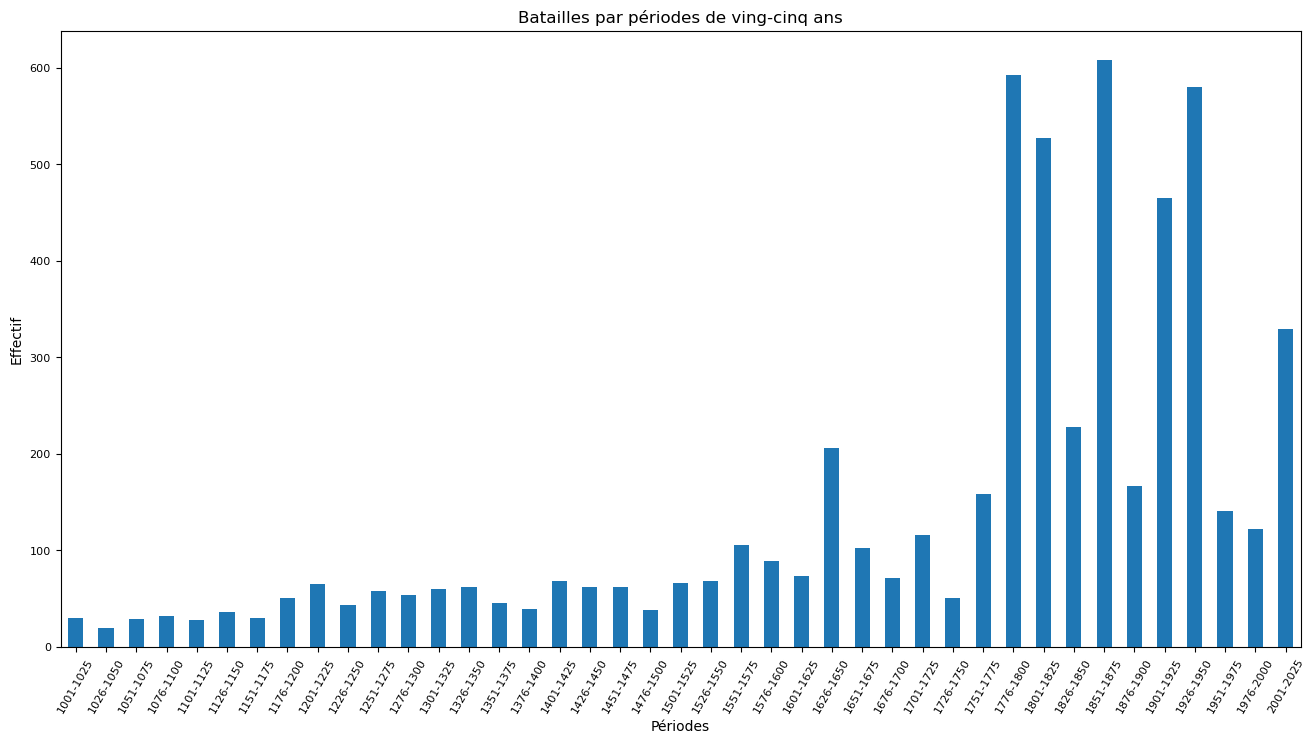

In [59]:
ax = cdf_b.groupby(by='periodes').size().plot(kind='bar',rot=60, fontsize=8, figsize=(16,8))
plt.ylabel('Effectif')
plt.xlabel('Périodes')
plt.title('Batailles par périodes de ving-cinq ans')
plt.show()

### Afficher les durées 

In [60]:
cdf_b.head(3)

,uri,label,geo_coordinates,battle_date,start_time,end_time,year,days_duration,periodes
0,http://www.wikidata.org/entity/Q459447,Siege of Yorktown,Point(-76.5025 37.230833333),1781-01-01T00:00:00Z,1781-09-28T00:00:00Z,1781-10-19T00:00:00Z,1781,22,1776-1800
1,http://www.wikidata.org/entity/Q242644,Battle of Caporetto,Point(13.6425 46.214444444),1917-11-19T00:00:00Z,1917-10-24T00:00:00Z,1917-11-19T00:00:00Z,1917,27,1901-1925
2,http://www.wikidata.org/entity/Q326115,Second Siege of Gerona,Point(2.816666666 41.983333333),1808-08-16T00:00:00Z,1808-07-24T00:00:00Z,1808-08-16T00:00:00Z,1808,24,1801-1825


In [61]:
df_cdf_b = pd.DataFrame(cdf_b[['label', 'year', 'days_duration' ]][cdf_b['days_duration'] > 1000])
#df_cdf_b.columns=['lustre', 'femmes']
df_cdf_b.head()

,label,year,days_duration
84,Siege of Bursa,1326,3391
105,Siege of Bursa,1326,3391
309,Battle of the Frontiers,1914,1864
318,Battle of Fuentes de Oñoro,1811,1450
799,Battle of Aleppo,2016,1618


In [62]:
cdf_b[cdf_b.days_duration < 1].head()

,uri,label,geo_coordinates,battle_date,start_time,end_time,year,days_duration,periodes
1019,http://www.wikidata.org/entity/Q125092483,Q125092483,Point(30.035944 61.7085),1614-01-01T00:00:00Z,1614-08-06T00:00:00Z,http://www.wikidata.org/.well-known/genid/5816...,1614,-1,1601-1625
1455,http://www.wikidata.org/entity/Q155302,Battle of Loigny-Poupry,Point(1.73389 48.1239),1870-12-02T00:00:00Z,,,1870,-1,1851-1875
1457,http://www.wikidata.org/entity/Q201692,Battle of Poitiers,Point(0.39 46.54),1356-09-19T00:00:00Z,,,1356,-1,1351-1375
1458,http://www.wikidata.org/entity/Q201692,Battle of Poitiers,Point(0.39 46.54),1356-09-17T00:00:00Z,,,1356,-1,1351-1375
1460,http://www.wikidata.org/entity/Q74391,Battle of Nauheim,Point(8.4633 49.9508),1762-08-30T00:00:00Z,,,1762,-1,1751-1775


In [63]:
### Regrouper et compter par génération avec la fonction Pandas 'groupby' (équivalente à la précédente)
# Pertinent en fonction de critères de domaine liés à l'âge
sans_duration = pd.DataFrame(cdf_b[cdf_b.days_duration < 1].groupby('periodes').size())
sans_duration.columns = ['effectif_sans']
sans_duration.tail()

,effectif_sans
periodes,
1901-1925,219
1926-1950,201
1951-1975,73
1976-2000,66
2001-2025,180


In [64]:
### Regrouper et compter par génération avec la fonction Pandas 'groupby' (équivalente à la précédente)
# Pertinent en fonction de critères de domaine liés à l'âge
avec_duration = pd.DataFrame(cdf_b[cdf_b.days_duration > 0].groupby('periodes').size())
avec_duration.columns = ['effectif_avec']
avec_duration.tail()

,effectif_avec
periodes,
1901-1925,246
1926-1950,379
1951-1975,68
1976-2000,56
2001-2025,149


In [65]:
merged = pd.merge(sans_duration, avec_duration, left_index=True, right_index=True)
merged.tail()

,effectif_sans,effectif_avec
periodes,,
1901-1925,219,246
1926-1950,201,379
1951-1975,73,68
1976-2000,66,56
2001-2025,180,149


In [66]:
merged.index = merged.index.map(str)
merged.tail()

,effectif_sans,effectif_avec
periodes,,
1901-1925,219,246
1926-1950,201,379
1951-1975,73,68
1976-2000,66,56
2001-2025,180,149


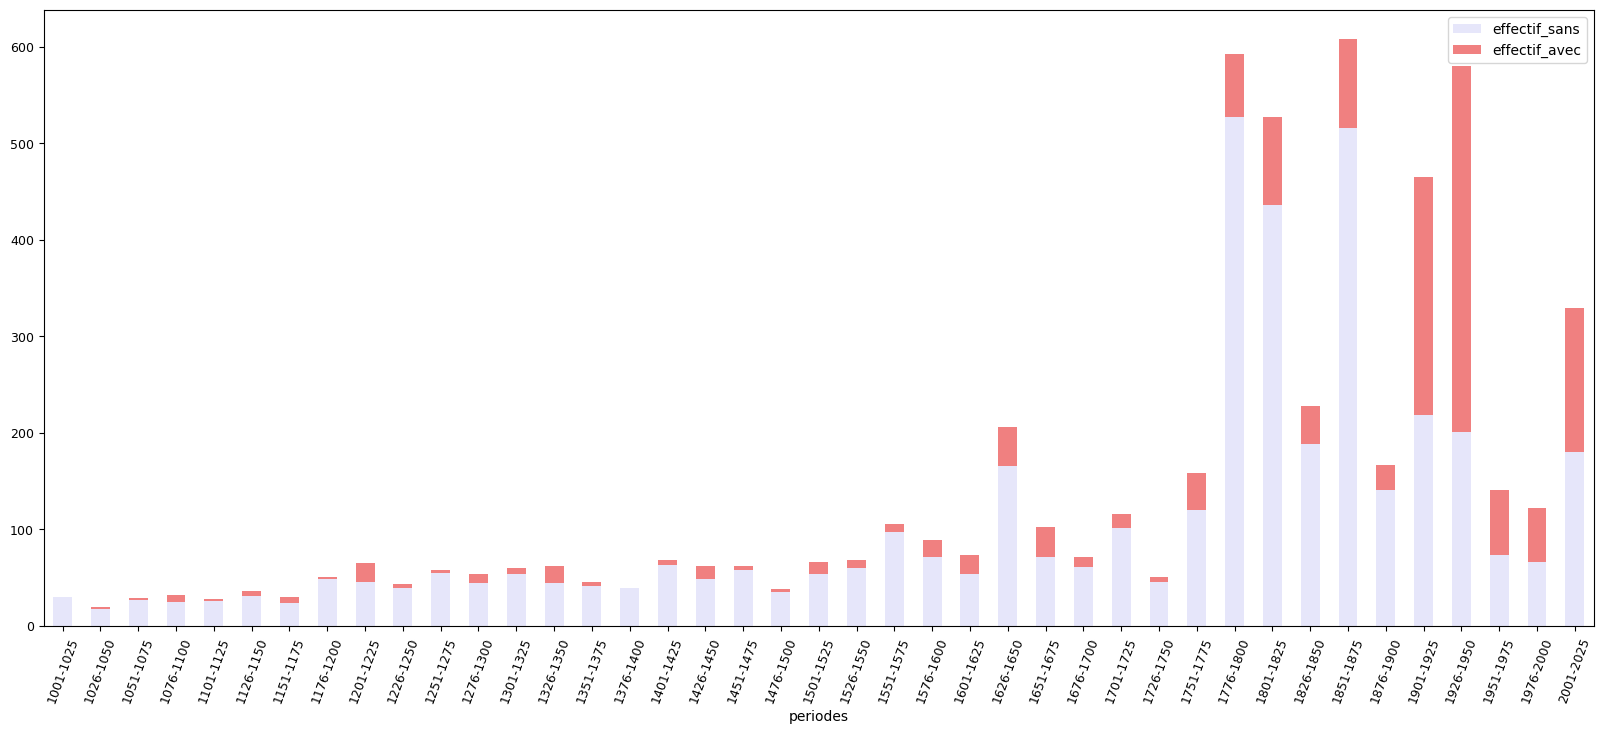

In [67]:
### Documentation
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.plot.bar.html
ax = merged.plot.bar(stacked=True, rot=70, fontsize=9, figsize=(20,8), color=['Lavender', 'LightCoral'])
plt.show()

In [70]:
### Médiane
df_b[(df_b.days_duration > 0) & (df_b.days_duration < 100)]
# https://datascienceparichay.com/article/pandas-groupby-median/
cdf_b[(cdf_b['days_duration'] > 0) & (cdf_b.days_duration < 100)]\
      .groupby(by='periodes')['days_duration'].median()

periodes
1001-1025     NaN
1026-1050     1.5
1051-1075     1.0
1076-1100     4.0
1101-1125     1.0
1126-1150     1.0
1151-1175     2.0
1176-1200     1.0
1201-1225     1.0
1226-1250     7.5
1251-1275     3.0
1276-1300     1.5
1301-1325     2.0
1326-1350     5.0
1351-1375     1.5
1376-1400     NaN
1401-1425    33.0
1426-1450     4.0
1451-1475    10.0
1476-1500    39.0
1501-1525    22.0
1526-1550    20.0
1551-1575    26.0
1576-1600     4.0
1601-1625    46.5
1626-1650    11.0
1651-1675     8.0
1676-1700     7.0
1701-1725    14.0
1726-1750    10.5
1751-1775    10.0
1776-1800     3.0
1801-1825     3.0
1826-1850     3.0
1851-1875     3.0
1876-1900     3.0
1901-1925     8.0
1926-1950     9.0
1951-1975     5.0
1976-2000     5.0
2001-2025     7.0
Name: days_duration, dtype: float64

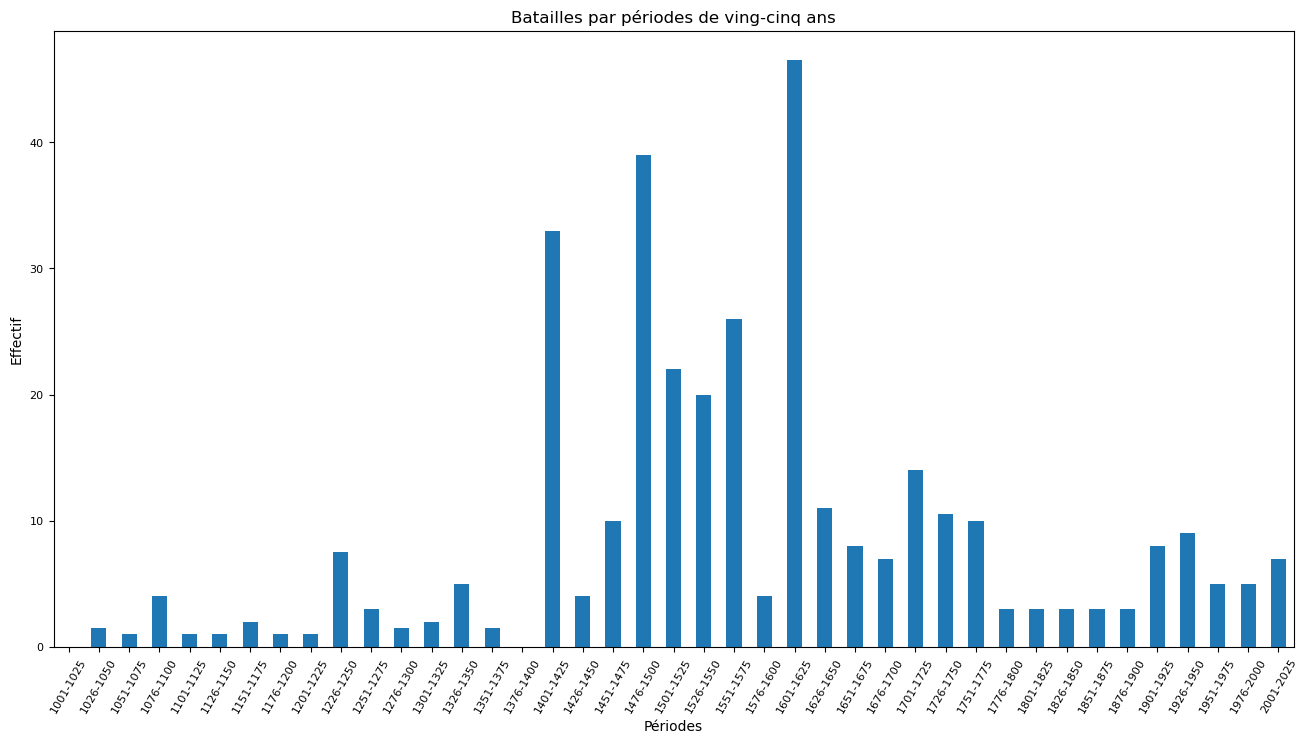

In [71]:
cdf_b[(cdf_b['days_duration'] > 0) & (cdf_b.days_duration < 100)]\
      .groupby(by='periodes')['days_duration'].agg('median')\
      .plot(kind='bar',rot=60, fontsize=8, figsize=(16,8))
plt.ylabel('Effectif')
plt.xlabel('Périodes')
plt.title('Batailles par périodes de ving-cinq ans')
plt.show()

In [72]:
cdf_b[(cdf_b['days_duration'] > 0)\
      & (cdf_b['periodes'].isin(['1051-1075', '1351-1375']))]\
      .sort_values(by='year', ascending=True)

,uri,label,geo_coordinates,battle_date,start_time,end_time,year,days_duration,periodes
1077,http://www.wikidata.org/entity/Q7509995,Siege of Exeter,Point(-3.529722222 50.725833333),1068-01-01T00:00:00Z,1068-01-01T00:00:00Z,1068-01-01T00:00:00Z,1068,1,1051-1075
671,http://www.wikidata.org/entity/Q815120,Siege of Bari,Point(16.866666666 41.125277777),1071-04-21T00:00:00Z,1068-08-11T00:00:00Z,1071-04-21T00:00:00Z,1071,984,1051-1075
532,http://www.wikidata.org/entity/Q3486017,Siege of Saint-Jean-d'Angély,Point(-0.521111111 45.944166666),1351-08-01T00:00:00Z,1351-03-01T00:00:00Z,1351-09-01T00:00:00Z,1351,185,1351-1375
858,http://www.wikidata.org/entity/Q1822262,Siege of Rennes,Point(-1.680833333 48.114166666),1356-10-11T00:00:00Z,1356-10-11T00:00:00Z,1357-07-13T00:00:00Z,1356,276,1351-1375
460,http://www.wikidata.org/entity/Q3485953,Battle of Mello,Point(2.887777777 48.959444444),1358-06-18T00:00:00Z,1358-06-17T00:00:00Z,1358-06-18T00:00:00Z,1358,2,1351-1375
488,http://www.wikidata.org/entity/Q3485938,Siege of Mantes,Point(1.71722 48.9908),1364-04-15T00:00:00Z,1364-04-15T00:00:00Z,1364-04-15T00:00:00Z,1364,1,1351-1375


In [73]:
### Regrouper et compter par génération avec la fonction Pandas 'groupby' (équivalente à la précédente)
# Pertinent en fonction de critères de domaine liés à l'âge
avec_duration = pd.DataFrame(cdf_b[cdf_b.days_duration > 0].groupby('periodes').size())
avec_duration.columns = ['effectif_avec']
avec_duration.tail()

,effectif_avec
periodes,
1901-1925,246
1926-1950,379
1951-1975,68
1976-2000,56
2001-2025,149


In [75]:
### Regrouper et compter par génération avec la fonction Pandas 'groupby' (équivalente à la précédente)
# Pertinent en fonction de critères de domaine liés à l'âge
avec_duration_median = pd.DataFrame(cdf_b[(cdf_b['days_duration'] > 0) & (cdf_b.days_duration < 100)].groupby('periodes')['days_duration'].agg('median'))
avec_duration_median.columns = ['median']
avec_duration_median.tail()

,median
periodes,
1901-1925,8.0
1926-1950,9.0
1951-1975,5.0
1976-2000,5.0
2001-2025,7.0


In [76]:
merged_median = pd.merge( avec_duration, avec_duration_median, left_index=True, right_index=True)
merged_median.tail()

,effectif_avec,median
periodes,,
1901-1925,246,8.0
1926-1950,379,9.0
1951-1975,68,5.0
1976-2000,56,5.0
2001-2025,149,7.0


In [77]:
merged_median.index = merged_median.index.map(str)
merged_median.tail()

,effectif_avec,median
periodes,,
1901-1925,246,8.0
1926-1950,379,9.0
1951-1975,68,5.0
1976-2000,56,5.0
2001-2025,149,7.0


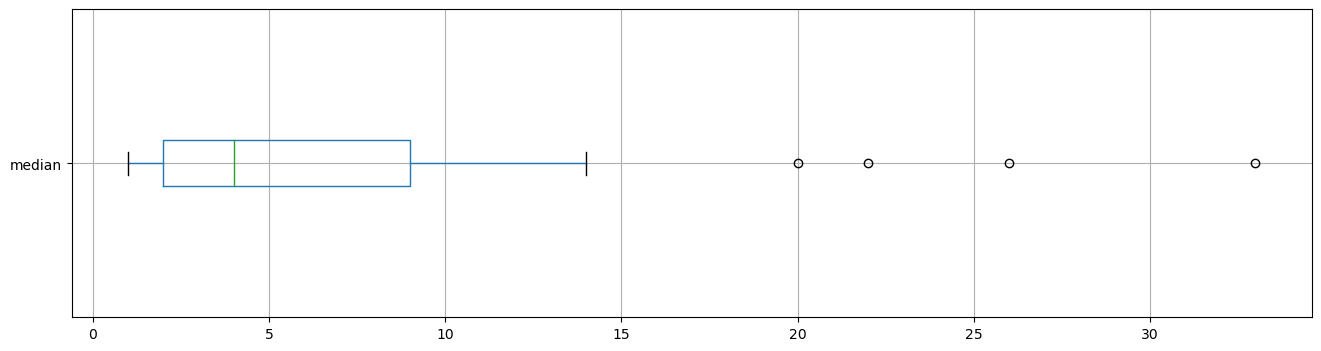

In [78]:

merged_median[merged_median['median'] < 35].boxplot(column=['median'], vert=False, figsize=(16,4))
plt.show()

In [90]:
medians = list(merged_median[merged_median['median'] < 20]['median'].fillna(0))
print(sorted(medians), len(medians))

[1.0, 1.0, 1.0, 1.0, 1.0, 1.5, 1.5, 1.5, 2.0, 2.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 4.0, 4.0, 4.0, 5.0, 5.0, 5.0, 7.0, 7.0, 7.5, 8.0, 8.0, 9.0, 10.0, 10.0, 10.5, 11.0, 14.0] 33


In [84]:
from matplotlib.colors import ListedColormap, LinearSegmentedColormap, Normalize

In [97]:
colormap_1 = LinearSegmentedColormap.from_list('colorbar', ['#D8B5FF','#1EAE98'], N=len(medians))
norm = Normalize(vmin=min(medians), vmax=max(medians))
colors = [colormap_1(norm(v)) for v in medians]

In [98]:
colors[:3]

[(0.8242647058823529, 0.7089460784313726, 0.9873774509803922, 1.0),
 (0.8470588235294118, 0.7098039215686275, 1.0, 1.0),
 (0.6875, 0.7037990196078432, 0.9116421568627451, 1.0)]

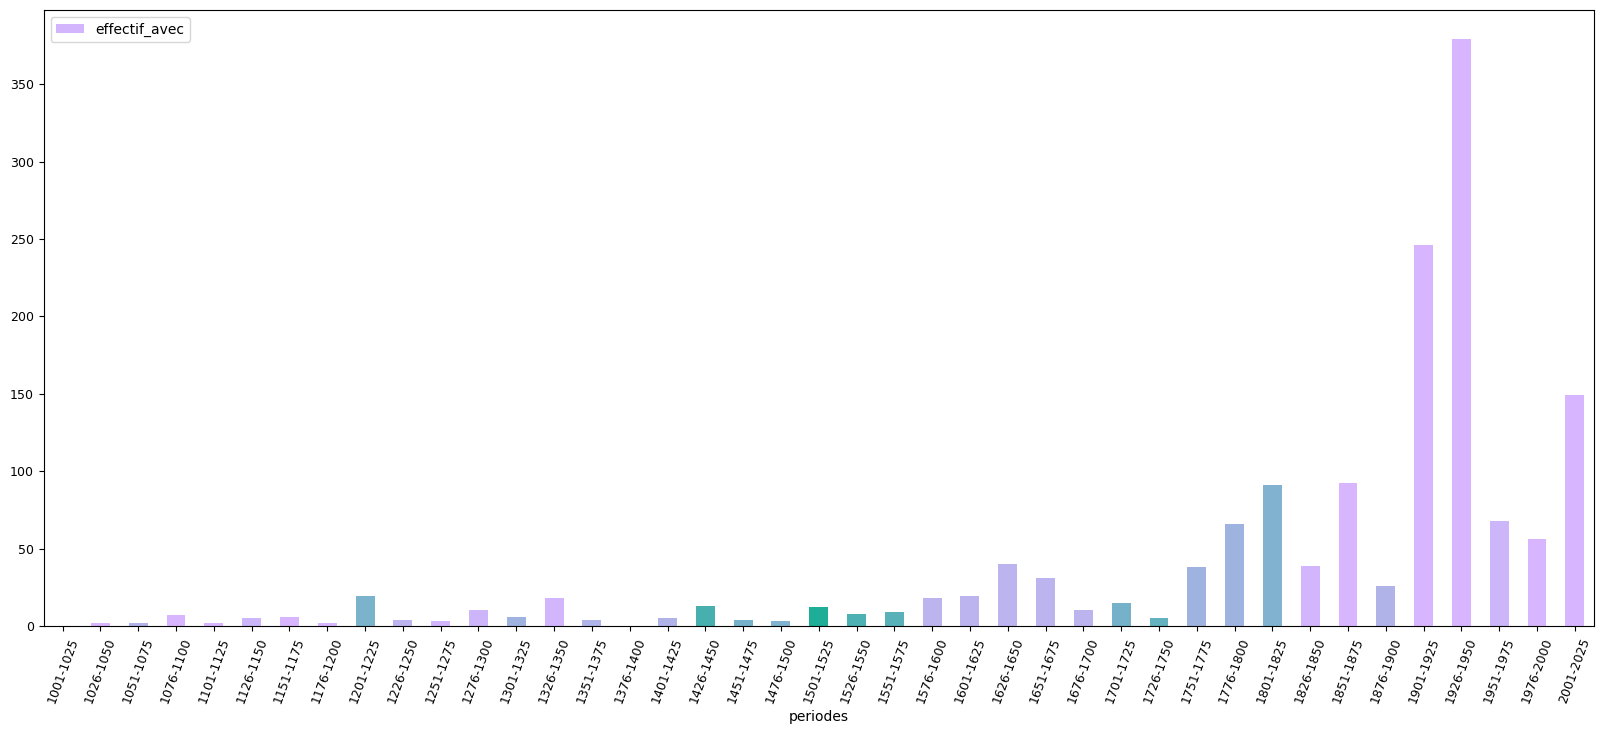

In [104]:
### Documentation
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.plot.bar.html
## pour les couleurs
# https://stackoverflow.com/questions/60132409/use-a-third-column-of-values-to-map-a-color-gradient-to-a-plot-of-column-1-and-c

ax = merged_median.plot.bar(rot=70, y='effectif_avec', fontsize=9, figsize=(20,8), color = colors)
plt.show()

In [94]:
print(medians)

[1.5, 1.0, 4.0, 1.0, 1.0, 2.0, 1.0, 1.0, 7.5, 3.0, 1.5, 2.0, 5.0, 1.5, 4.0, 10.0, 4.0, 11.0, 8.0, 7.0, 14.0, 10.5, 10.0, 3.0, 3.0, 3.0, 3.0, 3.0, 8.0, 9.0, 5.0, 5.0, 7.0]


In [100]:
cdf_b[cdf_b.periodes.isin(['1426-1450'])]

,uri,label,geo_coordinates,battle_date,start_time,end_time,year,days_duration,periodes
39,http://www.wikidata.org/entity/Q283015,Battle of Beaugency,Point(1.64917 46.7958),1429-06-26T00:00:00Z,1429-07-04T00:00:00Z,1429-07-05T00:00:00Z,1429,2,1426-1450
50,http://www.wikidata.org/entity/Q392213,Siege of Orléans,Point(1.90889 47.9025),1428-10-21T00:00:00Z,1428-10-30T00:00:00Z,1429-05-26T00:00:00Z,1428,209,1426-1450
295,http://www.wikidata.org/entity/Q668577,Siege of Compiègne,Point(2.822222222 49.414166666),1430-11-01T00:00:00Z,1430-06-07T00:00:00Z,1430-11-15T00:00:00Z,1430,162,1426-1450
310,http://www.wikidata.org/entity/Q600016,Battle of Jargeau,Point(2.122222222 47.866666666),1429-06-21T00:00:00Z,1429-06-29T00:00:00Z,1429-06-30T00:00:00Z,1429,2,1426-1450
439,http://www.wikidata.org/entity/Q698706,Battle of Kosovo,Point(21.12 42.63),1448-10-29T00:00:00Z,1448-10-26T00:00:00Z,1448-10-29T00:00:00Z,1448,4,1426-1450
...,...,...,...,...,...,...,...,...,...
5501,http://www.wikidata.org/entity/Q12754327,Battle of Kunovica,Point(22.1761 43.1803),1444-01-14T00:00:00Z,,,1444,-1,1426-1450
5504,http://www.wikidata.org/entity/Q12336015,Battle of St. Jørgensbjerg,Point(9.2932 57.0624),1441-06-17T00:00:00Z,,,1441,-1,1426-1450
6167,http://www.wikidata.org/entity/Q32832,Battle of Varna,Point(27.883333333 43.216666666),1444-11-10T00:00:00Z,,,1444,-1,1426-1450
6249,http://www.wikidata.org/entity/Q117812087,Battle of Zbraslav,Point(14.391 49.979),1429-05-02T00:00:00Z,,,1429,-1,1426-1450
